# Synthetic data

In [1]:
!pwd
import os
# os.chdir('..') # for server this isnt reqd
from bilevel.synth_datagen import SynthGenLinear

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

/home/jupyter-kriach/md_github_lat/multigroupcode/multigroup-code


In [2]:
import pickle
def save_ob(name, obj):
    with open(name, 'wb') as handle:
        pickle.dump(obj, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
def load_ob(name):
    with open(name, 'rb') as handle:
        obj = pickle.load(handle)
    return obj

In [3]:
def performance_diff(ds_obj):
    df_res = pd.concat([ds_obj.df_base_meansd, ds_obj.df_Anh_meansd], axis=1)
    df_res['base_minus_Anh'] = df_res['mean_base'] - df_res['mean_Anh']
    df_res['discount_from_base'] = (df_res['base_minus_Anh'] / df_res['mean_base'])*100
    return df_res

In [4]:
# call only one time, used the saved syn_ob below
params = {'samples': 100000, 'dim':20, 
        'group_dict': {'SEX':['male', 'female'], 'RACE': ['white', 'black', 'two-or-more','some-other', 'asian', 'native-am']},
        'prob_dict': {'SEX': [0.5, 0.5], 'RACE': [0.61, 0.12, 0.1, 0.08, 0.06, 0.03]},
        'feat_lo': 0.0, 'feat_hi': 1.0, 'w_lo': 0.0, 'w_hi': 1.0,
        'add_linear_mapping': True, 'add_quad_mapping' : False, 
        'S_lo': 0.0, 'S_hi':0.0,
        'label_noise_width':0.16, 'drop_sensitive':False, 'fixed_seed':42,
        }
syn_ob = SynthGenLinear(**params)
print(syn_ob.dperm, np.array(syn_ob.all_groupnames)[syn_ob.dperm])
df = syn_ob.df

[0 7 6 1 3 5 2 4] ['male' 'native-am' 'asian' 'female' 'black' 'some-other' 'white'
 'two-or-more']


In [5]:
save_ob('syn_ob_saved_seed42.pickle', syn_ob)

In [4]:
# import pickle
# with open('syn_ob_saved.pickle', 'wb') as handle:
#     pickle.dump(syn_ob, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [7]:
# import pickle
# with open('syn_ob_saved.pickle', 'rb') as handle:
#     syn_ob = pickle.load(handle)
# print(syn_ob.dperm, np.array(syn_ob.all_groupnames)[syn_ob.dperm])
# df = syn_ob.df

[3 0 5 7 2 4 1 6] ['black' 'male' 'some-other' 'native-am' 'white' 'two-or-more' 'female'
 'asian']


In [6]:
print(df.columns)
filter_feature = [col for col in df if col.startswith('x')]
filter_label = [col for col in df if col.startswith('y')]
filter_group = [col for col in df if col.startswith('g')]
print(filter_feature, filter_label, filter_group)

Index(['x_0', 'x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6', 'x_7', 'x_8', 'x_9',
       'x_10', 'x_11', 'x_12', 'x_13', 'x_14', 'x_15', 'x_16', 'x_17', 'x_18',
       'x_19', 'g_male', 'g_female', 'g_white', 'g_black', 'g_two-or-more',
       'g_some-other', 'g_asian', 'g_native-am', 'y_male', 'y_female',
       'y_white', 'y_black', 'y_two-or-more', 'y_some-other', 'y_asian',
       'y_native-am', 'y_mean_active', 'y_min_active', 'y_max_active',
       'y_dperm_active'],
      dtype='object')
['x_0', 'x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6', 'x_7', 'x_8', 'x_9', 'x_10', 'x_11', 'x_12', 'x_13', 'x_14', 'x_15', 'x_16', 'x_17', 'x_18', 'x_19'] ['y_male', 'y_female', 'y_white', 'y_black', 'y_two-or-more', 'y_some-other', 'y_asian', 'y_native-am', 'y_mean_active', 'y_min_active', 'y_max_active', 'y_dperm_active'] ['g_male', 'g_female', 'g_white', 'g_black', 'g_two-or-more', 'g_some-other', 'g_asian', 'g_native-am']


## Note about features and labels
- x_0...x_19 are the features, y_mean, min, max, dperm are the labels
- also include group membership in features!, group memberships are
    Race groups, Sex groups

In [7]:
syn_ob.A_t.shape

(100000, 8)

In [8]:
syn_ob.A_t.sum(axis=0), syn_ob.all_groupnames

(array([49934., 50066., 60891., 11931., 10194.,  7932.,  6018.,  3034.]),
 ['male',
  'female',
  'white',
  'black',
  'two-or-more',
  'some-other',
  'asian',
  'native-am'])

In [9]:
A_t = pd.DataFrame(syn_ob.A_t, columns = syn_ob.all_groupnames) # A_t dataframe
A_t['always_on'] = 1

In [10]:
df_mean = df[filter_feature+filter_group + ['y_mean_active']]
df_min = df[filter_feature+filter_group + ['y_min_active']]
df_max = df[filter_feature+filter_group + ['y_max_active']]
df_dperm = df[filter_feature+filter_group + ['y_dperm_active']]

In [11]:
from bilevel.Groupwise_seedruns import BuildGroupwise_diffseeds

## y_mean

In [12]:
%%time
ds_ymean = BuildGroupwise_diffseeds(df_mean, 'y_mean_active', A_t) # different seeds object
ds_ymean.build_all_seeds()
ds_ymean.build_df_res()
ds_ymean.build_regret_curve()

100%|██████████| 100000/100000 [00:12<00:00, 7825.98it/s]


CPU times: user 6min 27s, sys: 10.2 s, total: 6min 38s
Wall time: 3min 4s


In [13]:
save_ob('syn_ymean_seeds.pickle', ds_ymean)

In [14]:
from bilevel.Groupwise_seedruns import plot_subgroups
subgroups_list = [['male', 'female'], ['white', 'black', 'two-or-more','some-other', 'asian', 'native-am'], ['always_on']]
# plot_subgroups(ds_ob, subgroups_list)

male 49934


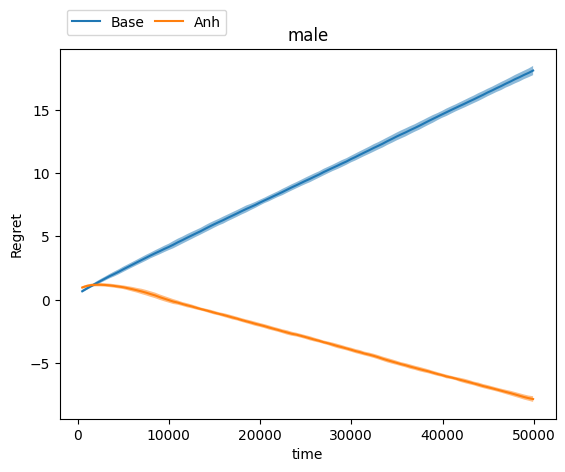

female 50066


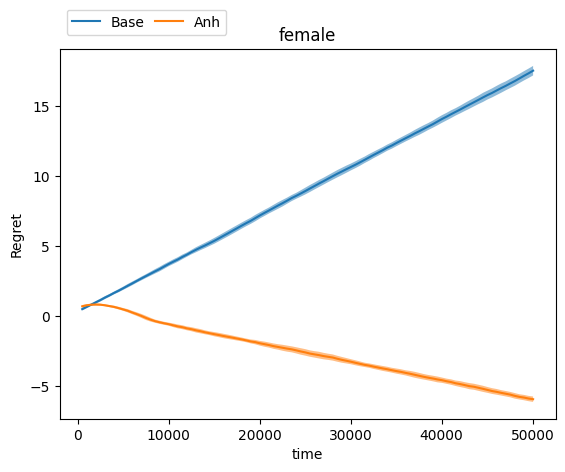

white 60891


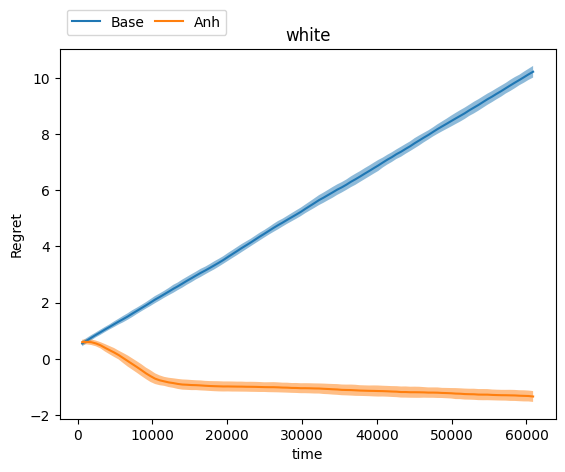

black 11931


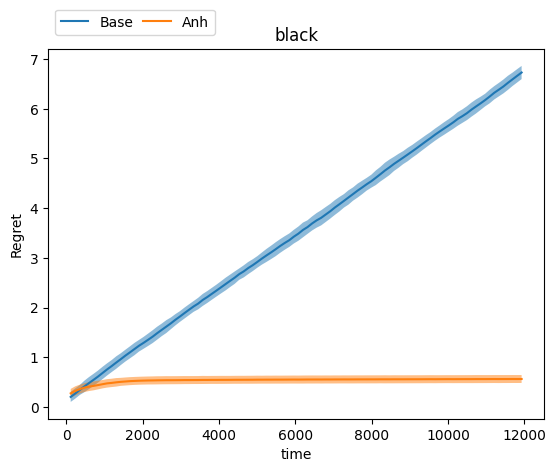

two-or-more 10194


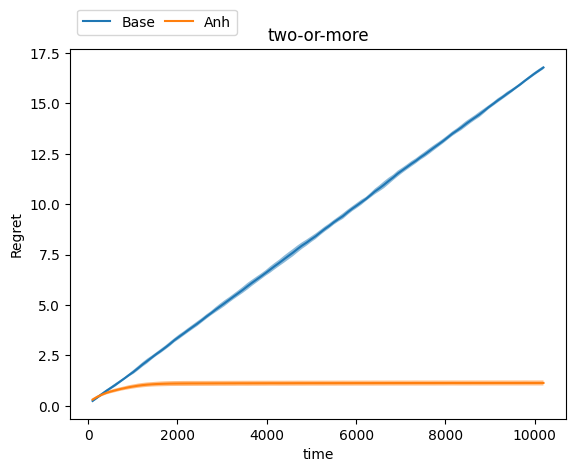

some-other 7932


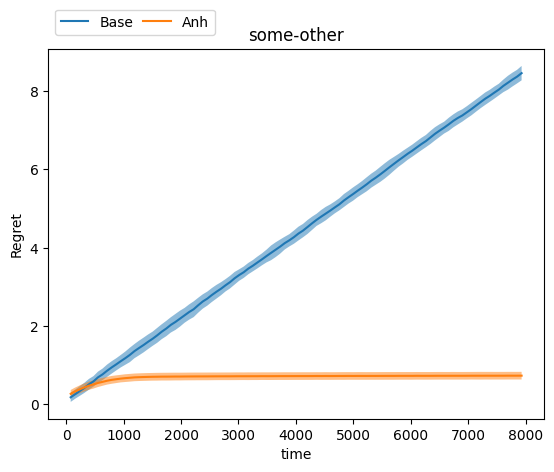

asian 6018


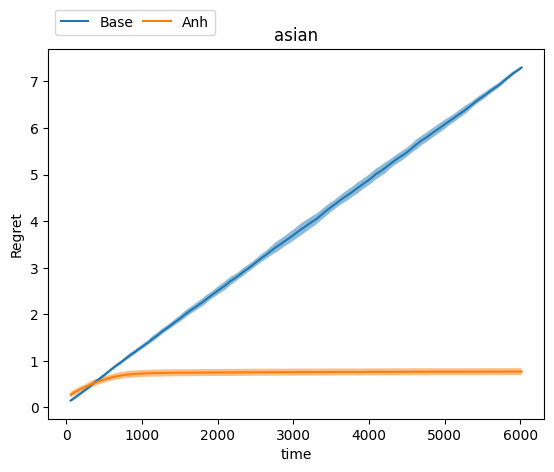

native-am 3034


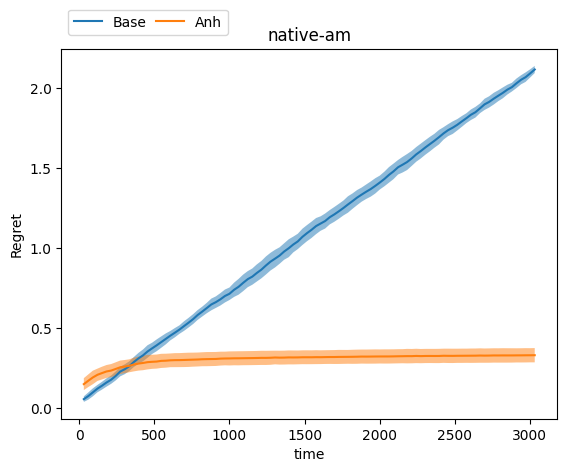

always_on 100000


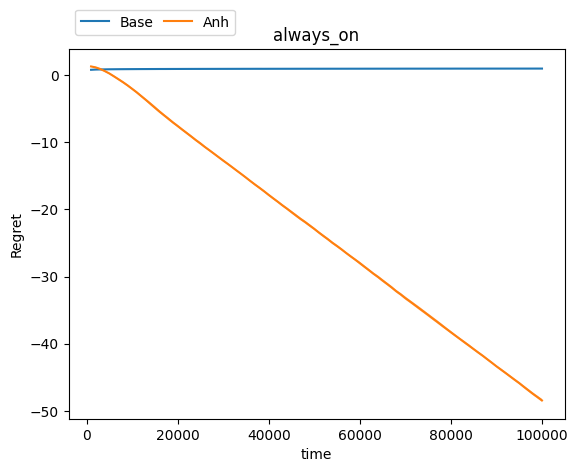

In [15]:
from bilevel.Groupwise_seedruns import plot_regret_curve_with_std
plot_regret_curve_with_std(ds_ymean)

## y_min

In [16]:
%%time
ds_ymin = BuildGroupwise_diffseeds(df_min, 'y_min_active', A_t) # different seeds object
ds_ymin.build_all_seeds()
ds_ymin.build_df_res()
ds_ymin.build_regret_curve()

100%|██████████| 100000/100000 [00:12<00:00, 8090.74it/s]


CPU times: user 6min 1s, sys: 9.5 s, total: 6min 11s
Wall time: 2min 59s


In [17]:
save_ob('syn_ymin_seeds.pickle', ds_ymin)

male 49934


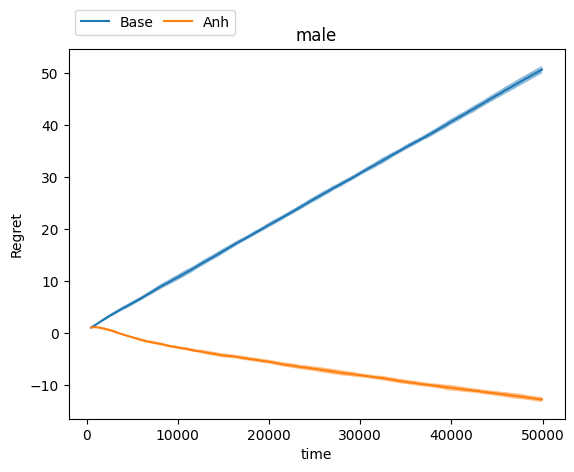

female 50066


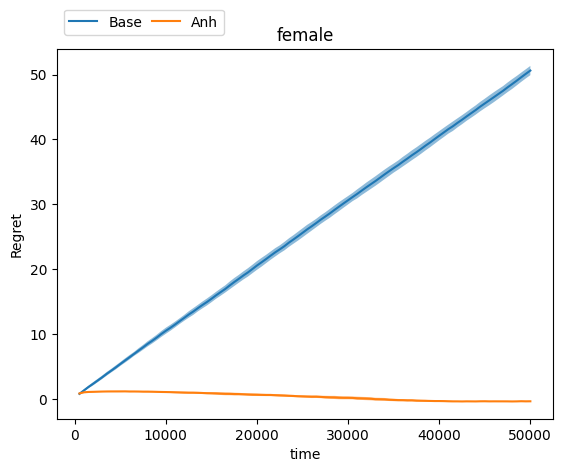

white 60891


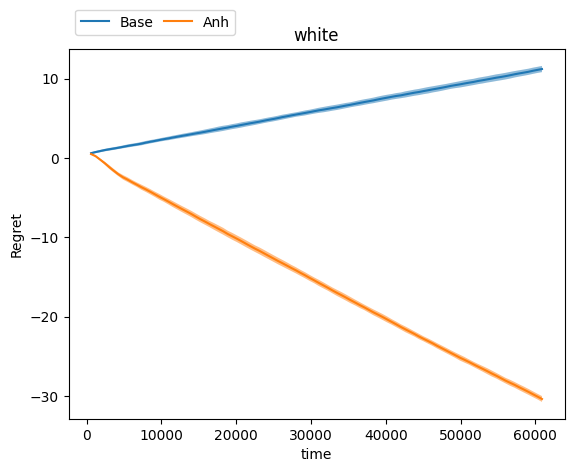

black 11931


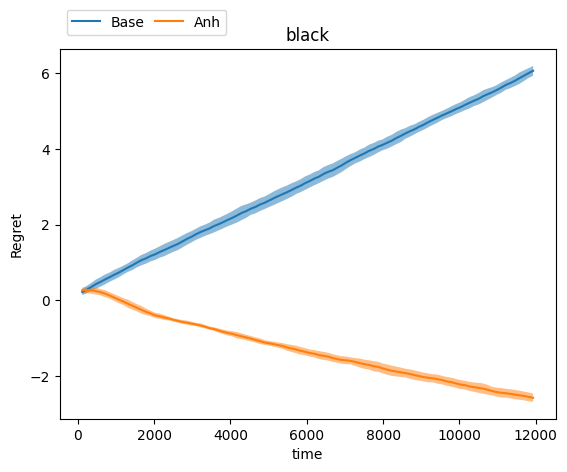

two-or-more 10194


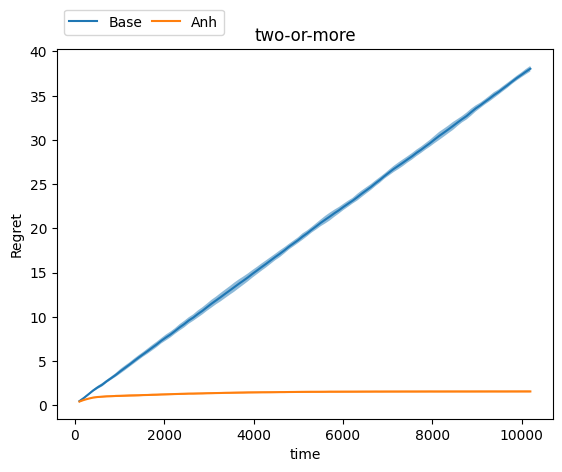

some-other 7932


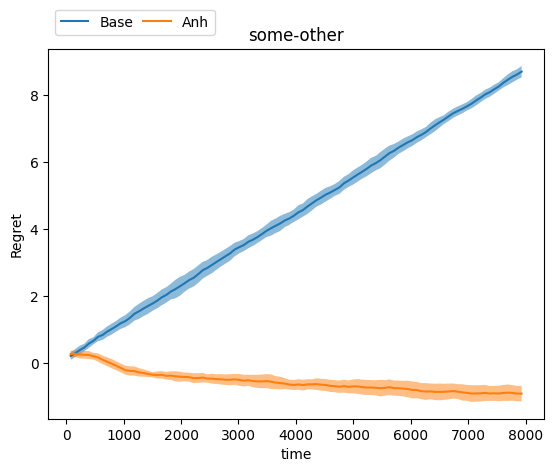

asian 6018


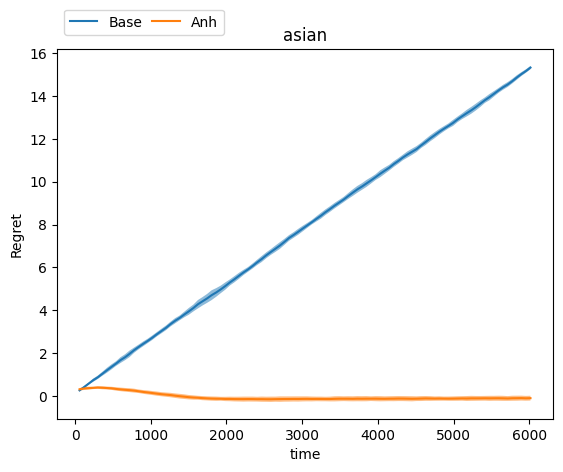

native-am 3034


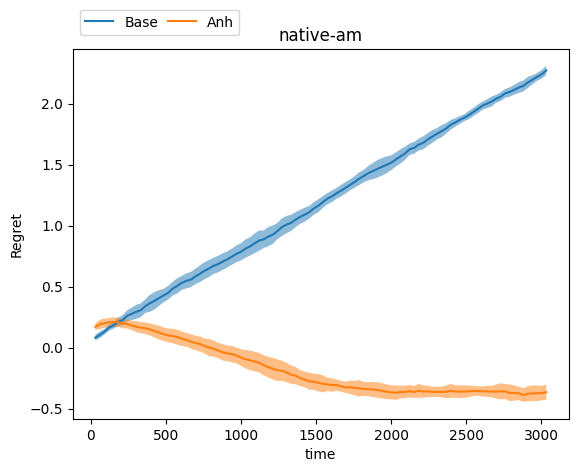

always_on 100000


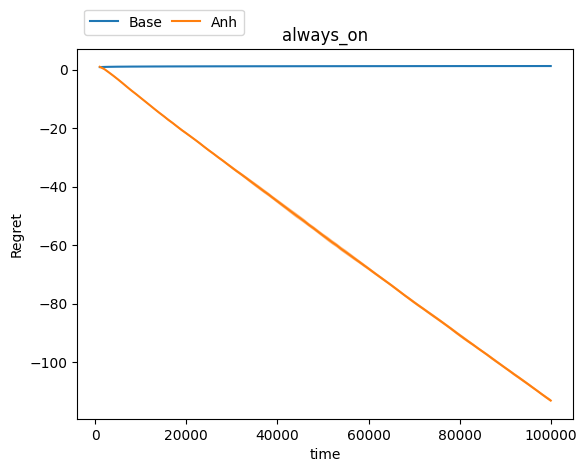

In [18]:
plot_regret_curve_with_std(ds_ymin)

In [19]:
# pd.concat([ds_ymin.df_base_meansd, ds_ymin.df_Anh_meansd], axis=1)

## y_max

In [20]:
ds_ymax = BuildGroupwise_diffseeds(df_max, 'y_max_active', A_t) # different seeds object
ds_ymax.build_all_seeds()
ds_ymax.build_df_res()
ds_ymax.build_regret_curve()

100%|██████████| 100000/100000 [00:12<00:00, 8110.09it/s]


In [21]:
save_ob('syn_ymax_seeds.pickle', ds_ymax)

male 49934


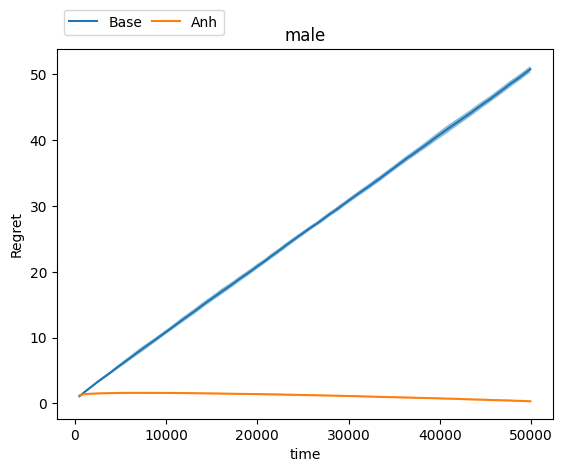

female 50066


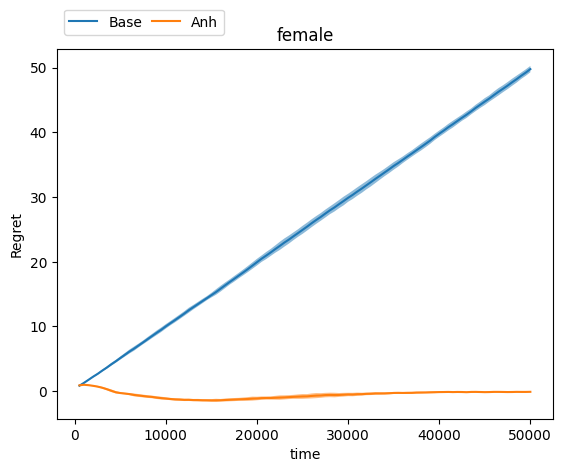

white 60891


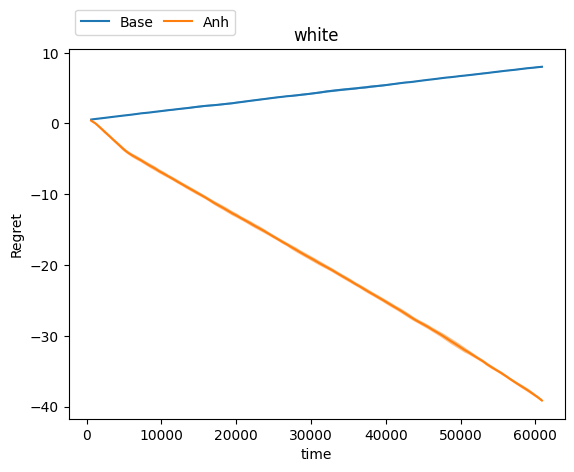

black 11931


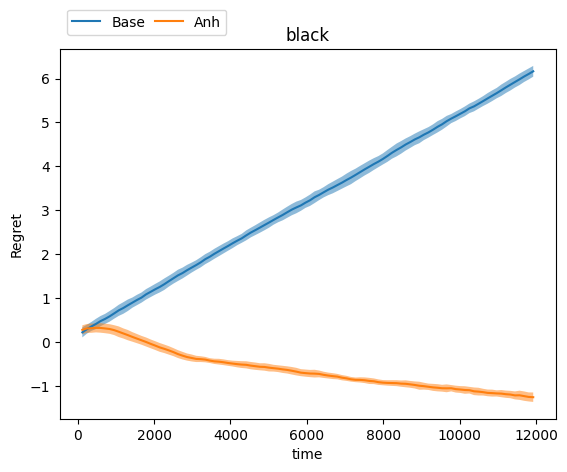

two-or-more 10194


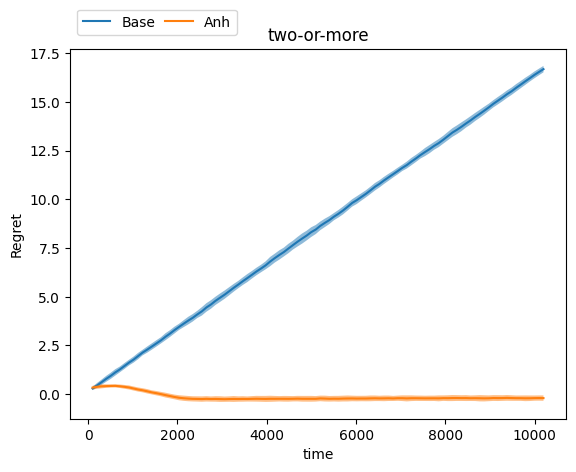

some-other 7932


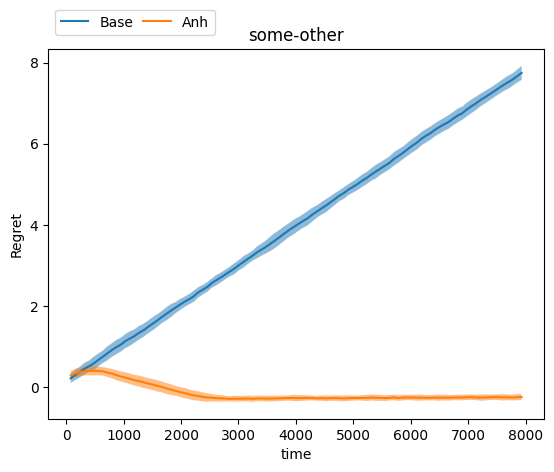

asian 6018


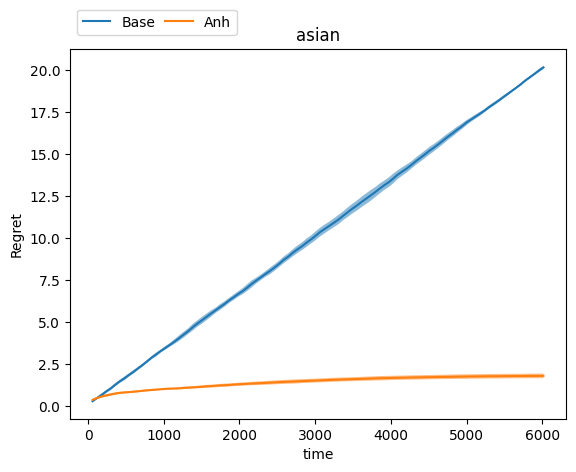

native-am 3034


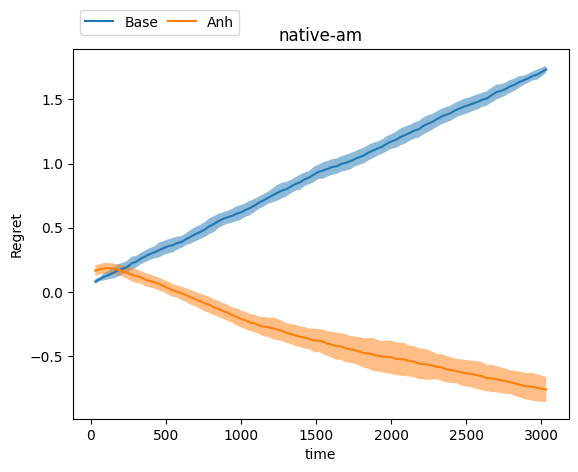

always_on 100000


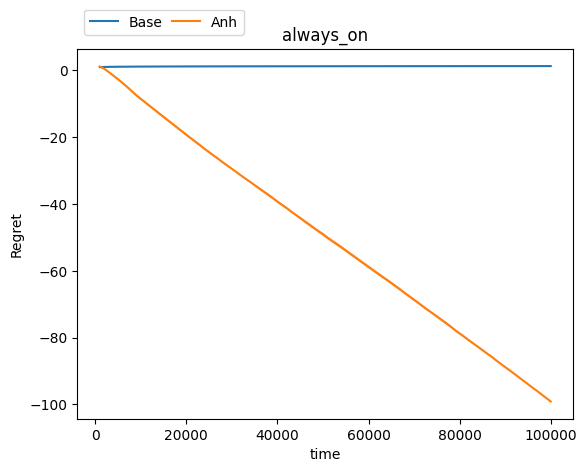

In [22]:
plot_regret_curve_with_std(ds_ymax)

## y_dperm

In [23]:
ds_ydperm = BuildGroupwise_diffseeds(df_dperm, 'y_dperm_active', A_t) # different seeds object
ds_ydperm.build_all_seeds()
ds_ydperm.build_df_res()
ds_ydperm.build_regret_curve()

100%|██████████| 100000/100000 [00:12<00:00, 8122.62it/s]


In [24]:
save_ob('syn_ydperm_seeds.pickle', ds_ydperm)

male 49934


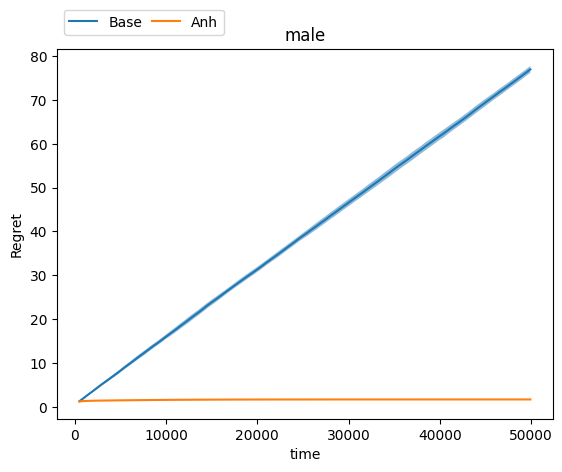

female 50066


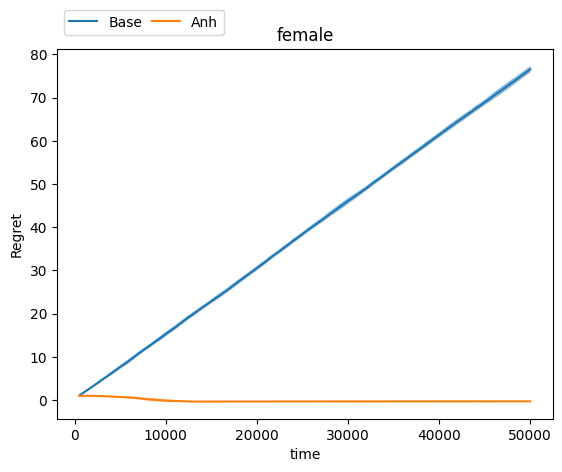

white 60891


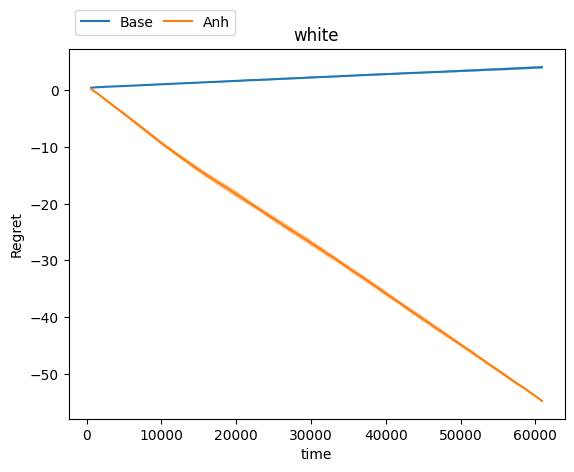

black 11931


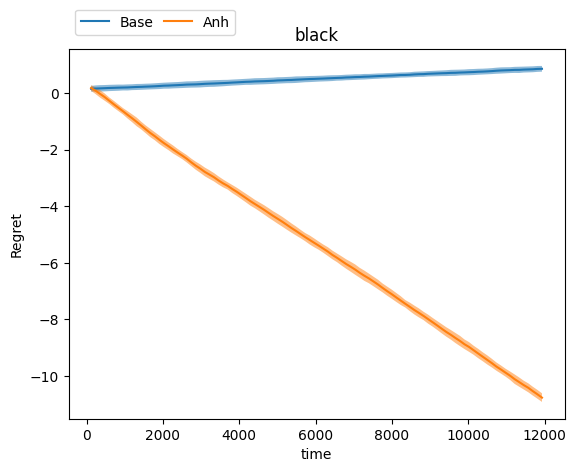

two-or-more 10194


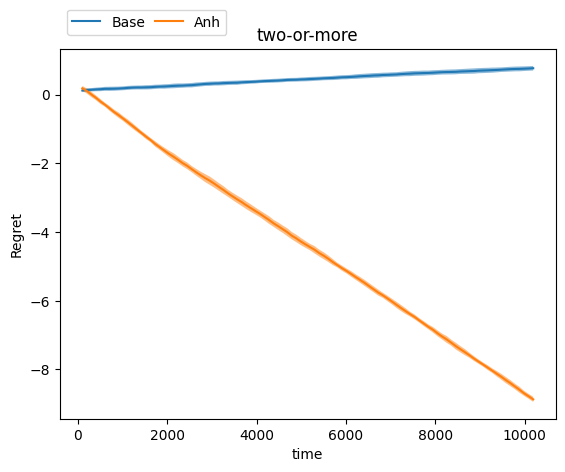

some-other 7932


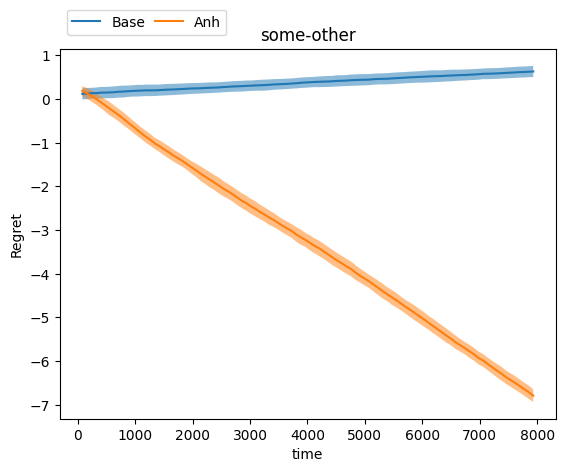

asian 6018


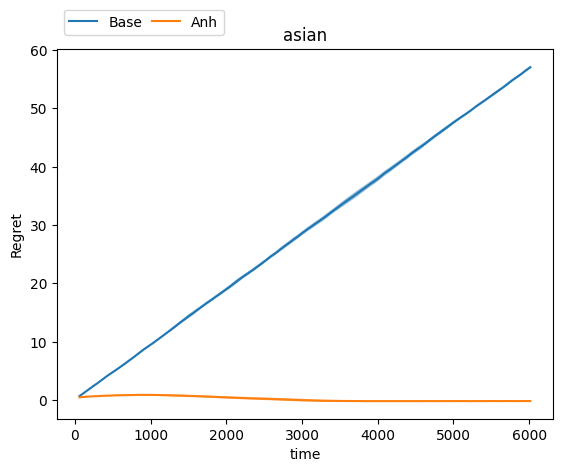

native-am 3034


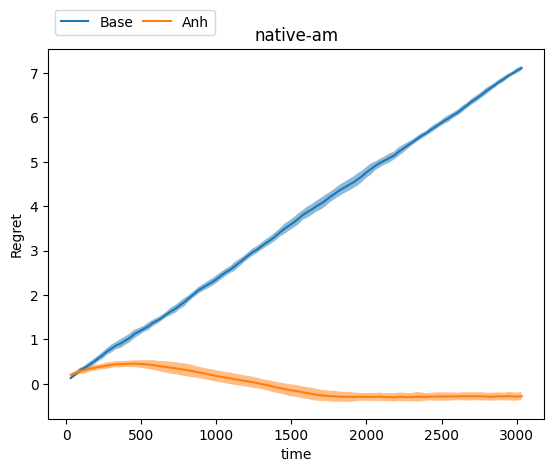

always_on 100000


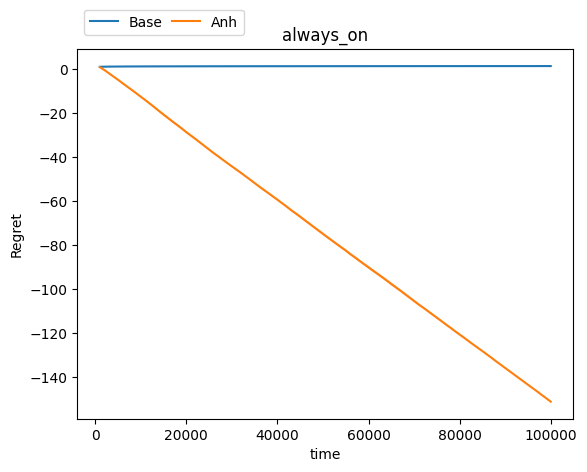

In [25]:
plot_regret_curve_with_std(ds_ydperm)

In [26]:
ds_ydperm.regret_Base_groupwise_array[-1].mean(axis=0), ds_ydperm.regret_Anh_groupwise_array[-1].mean(axis=0)

(array([0.85727303, 0.90996205, 0.94130017, 0.96304128, 0.97831962,
        0.99068605, 1.00150989, 1.01272009, 1.01905923, 1.02802273,
        1.03725283, 1.04288441, 1.04486531, 1.05188583, 1.06046654,
        1.06044642, 1.06397765, 1.07015263, 1.07317743, 1.07514805,
        1.08109021, 1.08737693, 1.0844914 , 1.08830775, 1.09403315,
        1.09298502, 1.09565634, 1.09742047, 1.10195339, 1.10353976,
        1.10642593, 1.10701132, 1.11102893, 1.11256725, 1.11603158,
        1.11605028, 1.12060841, 1.12155286, 1.12143754, 1.12242088,
        1.12391887, 1.12639141, 1.12797421, 1.12992692, 1.13092014,
        1.13308399, 1.13560346, 1.13629761, 1.13765507, 1.13774009,
        1.14246452, 1.14068999, 1.14310439, 1.14576694, 1.1449261 ,
        1.14764081, 1.14822804, 1.14825322, 1.14939895, 1.15168177,
        1.15226063, 1.15327986, 1.15360418, 1.15575501, 1.15624894,
        1.158441  , 1.15974194, 1.1609081 , 1.1602347 , 1.16158934,
        1.16161414, 1.16431952, 1.16483641, 1.16

## checks which aggregation is the best for Anh

In [27]:
performance_diff(ds_ymean)

,mean_base,std_base,mean_Anh,std_Anh,base_minus_Anh,discount_from_base
male,59.253785,0.384541,33.309804,0.238682,25.943982,43.784514
female,58.466392,0.358469,34.990545,0.204545,23.475848,40.152722
white,50.526708,0.218278,38.968841,0.203576,11.557867,22.874767
black,14.780371,0.140301,8.610642,0.084795,6.169729,41.742720
two-or-more,23.320034,0.082251,7.666751,0.131813,15.653284,67.123759
some-other,13.653207,0.193182,5.928481,0.102765,7.724726,56.578104
asian,11.295783,0.037629,4.768018,0.077987,6.527765,57.789395
native-am,4.144076,0.023253,2.357615,0.047027,1.786460,43.108778
always_on,117.720178,0.049321,68.300348,0.239161,49.419829,41.980764


In [28]:
performance_diff(ds_ymin)

,mean_base,std_base,mean_Anh,std_Anh,base_minus_Anh,discount_from_base
male,163.424416,0.753783,99.964827,0.497845,63.459590,38.831156
female,95.922347,0.751280,44.998603,0.067322,50.923744,53.088509
white,116.831840,0.412519,75.238054,0.389023,41.593786,35.601413
black,25.834232,0.136076,17.185826,0.116970,8.648406,33.476537
two-or-more,52.542593,0.332760,16.063075,0.117368,36.479518,69.428470
some-other,29.749830,0.179967,20.139779,0.244466,9.610050,32.302875
asian,26.571881,0.082653,11.158098,0.118485,15.413783,58.007873
native-am,7.816388,0.039078,5.178598,0.063768,2.637789,33.746909
always_on,259.346763,0.040014,144.963430,0.500990,114.383333,44.104400


In [29]:
performance_diff(ds_ymax)

,mean_base,std_base,mean_Anh,std_Anh,base_minus_Anh,discount_from_base
male,87.104109,0.521878,36.652516,0.105956,50.451594,57.921026
female,140.988485,0.518447,91.111640,0.065093,49.876844,35.376538
white,118.719927,0.129007,71.572346,0.214287,47.147581,39.713283
black,21.197044,0.129767,13.773885,0.113449,7.423158,35.019781
two-or-more,34.993452,0.175727,18.103563,0.147303,16.889889,48.265854
some-other,20.586369,0.179147,12.592343,0.077542,7.994027,38.831649
asian,25.730387,0.094134,7.352673,0.146441,18.377714,71.424165
native-am,6.865415,0.028092,4.369346,0.102397,2.496070,36.357155
always_on,228.092594,0.049970,127.764156,0.126852,100.328438,43.985838


In [30]:
performance_diff(ds_ydperm)

,mean_base,std_base,mean_Anh,std_Anh,base_minus_Anh,discount_from_base
male,99.953466,0.831230,24.686885,0.099819,75.266581,75.301621
female,120.769957,0.807412,43.868018,0.050412,76.901939,63.676382
white,95.030162,0.254367,36.150655,0.179996,58.879507,61.958757
black,18.832666,0.107300,7.219892,0.160520,11.612774,61.662933
two-or-more,15.694240,0.070836,6.060829,0.078706,9.633411,61.381823
some-other,12.190293,0.132904,4.766317,0.150292,7.423976,60.900719
asian,66.327470,0.235114,9.090789,0.111509,57.236680,86.294081
native-am,12.648592,0.051328,5.266421,0.096037,7.382171,58.363581
always_on,220.723423,0.068335,68.554904,0.129431,152.168520,68.940812


In [31]:
# also check that df mean, min, max, dperm are same except ycol

In [32]:
df_mean.drop('y_mean_active', axis=1).equals(df_min.drop('y_min_active', axis=1))

True